# PRELIMINARIES

In [11]:
# !pip freeze > requirements.txt

In [3]:
import sys
import os

is_colab = 'google.colab' in sys.modules

if is_colab==True:
    from google.colab import files, output, drive
    drive.mount('/gdrive')
    %cd /gdrive
    print("You're on Google Colab")
else:
    print("You're on a PC")

if is_colab==True:
    if os.getcwd()!='/gdrive/My Drive/--DATA SCIENCE/PROJET4':
        os.chdir('My Drive/--DATA SCIENCE/PROJET4')
    !pip install -r requirements.txt
else:
    # make sure 'P4_functions.py' is in the current working directory
    file_required('/P4_functions.py')
    file_required('requirements.txt')
    !pip install -r requirements.txt

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive
You're on Google Colab


In [4]:
from P4_functions import *
import io
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor']='w'
import warnings
warnings.filterwarnings('ignore')
# from ipywidgets import interact, interact_manual
import dill
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_pca_correlation_graph
from sklearn.inspection import permutation_importance
import category_encoders as ce
import scipy.stats as st
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import * 
from sklearn.linear_model import *
from sklearn import metrics
from sklearn.compose import make_column_transformer

dictPdSettings = {'display.max_rows': 500, 'display.width': 100,
                    'display.max_colwidth': 500,
                    'display.float_format': lambda x: '%.2f' % x}
for k,v in dictPdSettings.items():
    pd.set_option(k,v)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.decomposition.pca module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


In [8]:
import platform; print(platform.platform())
import sys; print("Python", sys.version)
import numpy; print("NumPy", numpy.__version__)
import scipy; print("SciPy", scipy.__version__)
import sklearn; print("Scikit-Learn", sklearn.__version__)

Linux-4.19.104+-x86_64-with-Ubuntu-18.04-bionic
Python 3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]
NumPy 1.18.5
SciPy 1.4.1
Scikit-Learn 0.23.1


In [5]:
if is_colab==True:
    path_csv = 'DATA/Cleaned_data.csv' 
    # Importing database from my Drive
    print("2. Try to import in notebook from myDrive...")
else:
    path_csv = '../DATA/Cleaned_data.csv'
    # Importing database from a DATA directory
    print("2. Try to import in notebook from PC ('DATA')")

df = pd.read_csv(path_csv, sep=',', index_col='Unnamed: 0',
                 low_memory=True, encoding ='utf-8')

print("-----> importation of .csv in the notebook OK")

df['ZipCode'] = df['ZipCode'].apply(str).astype('object')
df['CouncilDistrictCode'] = df['CouncilDistrictCode'].apply(str).astype('object')

2. Try to import in notebook from myDrive...
-----> importation of .csv in the notebook OK


In [6]:
prop_Q_cols = ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
               'PropertyGFAParking', 'PropertyGFABuilding(s)',
               'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
               'ThirdLargestPropertyUseTypeGFA', 'BuildingAge',
               'MeanGFAperFloor', 'ParkingGFARatio', 'NbYearsCertified',
               'ExtsurfVolRatio',
            'Outlier'] # 'ENERGYSTARScore',
prop_C_cols = ['Neighborhood', 'ZipCode', 'CouncilDistrictCode',
               'BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseType',
               'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
               'CertifiedPreviousYear', 'EnergyProfile', 'MainEnergy']
target_cols = ['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions',
                'SiteEnergyUseWN(kBtu)_log', 'TotalGHGEmissions_log']

In [21]:
df_X = df[prop_Q_cols+prop_C_cols]
df_y1 = df['SiteEnergyUseWN(kBtu)']
df_y2 = df['TotalGHGEmissions']
group_col = 'PrimaryPropertyType'
X_tr, X_te, y1_tr, y1_te = train_test_split(df_X, df_y1,
                                            train_size=0.8, shuffle=True,
                                            stratify=df[group_col],
                                            random_state=14)
y1_log_tr, y1_log_te  = np.log(y1_tr), np.log(y1_te)

# MODELS

In [12]:
df_res = pd.DataFrame(dtype = 'object')

In [13]:
dict_models = {}

In [36]:
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor

reg = KNeighborsRegressor()
name_reg = 'KNN_rand'
param_grid={'preproc__strat_binary': ['ord'],
            'preproc__strat_low_card': ['ohe', 'bin', 'ord', 'hash', 'loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__strat_high_card': ['ohe', 'bin', 'ord', 'hash', 'loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__strat_quant': ['stand'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            name_reg+'__n_neighbors': [1,2,3,5,7,9,11,15,17], # 1,2,3,5,7,9,11,15,17
            name_reg+'__p': [1]} # 1,2

# refit is set by default with 'neg_root_mean_squared_error'
dict_models[name_reg] = \
     model_optimizer(CustTransformer(thresh_card=12),
                    name_reg, reg, param_grid,
                    X_tr, y1_tr,
                    cv_search=StratifiedKFold(5).split(X_tr,X_tr[group_col]),
                    scv_scores = ['neg_root_mean_squared_error', 
                                  'neg_mean_absolute_error',
                                  'r2'],
                    search_strat='rand', n_iter=200)

new_df_res = scv_perf_fetcher(name_reg, dict_models[name_reg])
df_res = pd.concat([df_res, new_df_res], axis=1)

Randomized
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed: 53.9min finished


In [34]:
df_res

,KNN_grid,KNN_rand,KNN_rand,KNN_rand
best_params,"{'KNN_grid__n_neighbors': 2, 'KNN_grid__p': 1, 'preproc__strat_binary': 'ord', 'preproc__strat_high_card': 'bin', 'preproc__strat_low_card': 'ohe', 'preproc__strat_quant': 'stand'}","{'preproc__strat_quant': 'stand', 'preproc__strat_low_card': 'ohe', 'preproc__strat_high_card': 'bin', 'preproc__strat_binary': 'ord', 'KNN_rand__p': 1, 'KNN_rand__n_neighbors': 2}","{'preproc__strat_quant': 'stand', 'preproc__strat_low_card': 'ohe', 'preproc__strat_high_card': 'bin', 'preproc__strat_binary': 'ord', 'KNN_rand__p': 1, 'KNN_rand__n_neighbors': 2}","{'preproc__strat_quant': 'stand', 'preproc__strat_low_card': 'ohe', 'preproc__strat_high_card': 'bin', 'preproc__strat_binary': 'ord', 'KNN_rand__p': 1, 'KNN_rand__n_neighbors': 2}"
mean_train_neg_root_mean_squared_error,-8345120.46,-8345120.46,-8305910.34,-8305910.34
std_train_neg_root_mean_squared_error,980439.74,980439.74,902061.77,902061.77
mean_train_neg_mean_absolute_error,-2526710.82,-2526710.82,-2569848.88,-2569848.88
std_train_neg_mean_absolute_error,324367.75,324367.75,126665.73,126665.73
mean_train_r2,0.86,0.86,0.87,0.87
std_train_r2,0.04,0.04,0.01,0.01
mean_test_neg_root_mean_squared_error,-16474532.43,-16474532.43,-16498274.42,-16498274.42
std_test_neg_root_mean_squared_error,10797802.21,10797802.21,7111223.37,7111223.37
mean_test_neg_mean_absolute_error,-6450443.71,-6450443.71,-4899071.46,-4899071.46


In [ ]:
best_params, df_sel, df_gscv_filt = filters_cv_results(knn_gscv,'KNN__n_neighbors')
df_sel.head(2)

In [ ]:
### A REPARER
plot_scv_multi_scores(knn_gscv, param='param_KNN__n_neighbors',
                      results=df_gscv_filt,
                      title="Results of GridSearch for KNN regressor")

Plotting the score of the model vs parameters

In [ ]:
### A REPARER (pbe multiscoring ?)
plot_1D_hyperparam_opt(knn_gscv, param='KNN__n_neighbors')

Plotting the score for two parameters

In [ ]:
### A REPARER ??
plot_2D_hyperparam_opt(gscv = knn_gscv, params=['KNN__n_neighbors', 'KNN__p'])

Plotting the predicted values against the true values in test set for different groups.

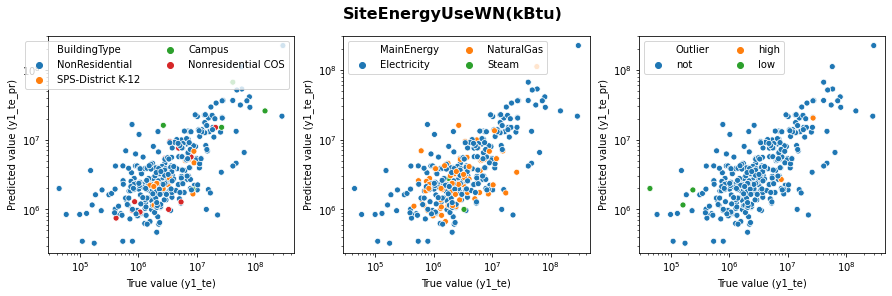

In [ ]:
y1_pr = knn_gscv.predict(X_te)

col_groups = ['BuildingType', 'MainEnergy', 'Outlier']
fig, axs = plt.subplots(1,len(col_groups))
for c, ax in zip(col_groups, axs):
    sns.scatterplot(y1_te, y1_pr, hue=X_te[c], ax=ax)
    ax.set_xscale('log'), ax.set_yscale('log'),
    ax.set_xlabel('True value (y1_te)')
    ax.set_ylabel('Predicted value (y1_te_pr)')
    ax.legend( ncol=2, )#bbox_to_anchor=(0.6,-0.2),
fig.suptitle('SiteEnergyUseWN(kBtu)', fontsize=16, fontweight='bold')
fig.set_size_inches(5*len(col_groups),4)
fig.set_facecolor('w')
plt.show()

Checking the importance of the features

Feature: 0, Score: 2738172851591.62500
Feature: 1, Score: 4955279784502.47461
Feature: 2, Score: 17223130674172.50000
Feature: 3, Score: 13258186165841.66211
Feature: 4, Score: 9612765094206.66211
Feature: 5, Score: 6396553000674.59961
Feature: 6, Score: 1768847532424.75000
Feature: 7, Score: 553631757053.52502
Feature: 8, Score: 731688576845.51245
Feature: 9, Score: 4214612269378.93750
Feature: 10, Score: 258773949496.89999
Feature: 11, Score: 775096973085.80005
Feature: 12, Score: -1686739822737.23755
Feature: 13, Score: 14008124324.62500
Feature: 14, Score: 3465224640736.16260
Feature: 15, Score: 11736152598661.07422
Feature: 16, Score: 344036811977.82501
Feature: 17, Score: -53259819473.85000
Feature: 18, Score: 23067382641072.02344
Feature: 19, Score: 27034590192672.77344
Feature: 20, Score: -1337390595122.52490
Feature: 21, Score: 8592140193664.13770
Feature: 22, Score: 1854296574845.87500
Feature: 23, Score: 5342032692703.06250
Feature: 24, Score: 1719053465329.67505


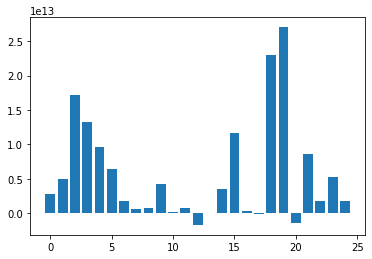

In [ ]:
# permutation feature importance with knn for regression

scv = XXXXXXXXXXXXXX

col_names = get_best_model_transf_df(scv, X_tr, y1_tr).columns

# perform permutation importance
results = permutation_importance(scv, X_te, y1_te, scoring='neg_mean_squared_error')
# get importance
importance = results.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

## Linear regression (no regularization)

In [ ]:
df_lr = pd.DataFrame(dtype = 'object')

#### 'SiteEnergyUse(kBtu)' target

With all the features

In [ ]:
reg = LinearRegression()
name_reg = 'LinReg(all)'

# pipe = make_pipeline(CustTransformer(thresh_card=12), reg)
pipe = Pipeline([("cust_trans", CustTransformer(thresh_card=12)), 
                 (name_reg, reg)])
pipe.fit(X_tr,y1_tr)

df_lr = get_append_scores(name_reg, pipe, X_te, y1_te, df_lr, cv=5)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.1s finished


In [ ]:
pipe.named_steps[name_reg].coef_
# sgd_randomized_pipe.best_estimator_.named_steps['clf']

array([ 9.52739456e+06, -2.59829038e+20, -2.59829038e+20, -2.59829038e+20,
        4.49113621e+19,  4.49113621e+19,  4.49113621e+19,  4.49113621e+19,
        4.49113621e+19,  4.49113621e+19,  4.49113621e+19, -2.93271108e+20,
       -2.93271108e+20, -2.93271108e+20, -2.93271108e+20,  2.63831721e+18,
        2.63831721e+18,  2.63831721e+18,  2.63831721e+18,  2.63831721e+18,
        2.63831721e+18,  2.63831721e+18,  2.63831721e+18, -5.44439283e+19,
       -5.44439283e+19, -5.44439283e+19,  1.48441067e+20,  1.48441067e+20,
        1.48441067e+20,  1.48441067e+20,  1.48441067e+20,  1.48441067e+20,
        1.48441067e+20,  1.48441067e+20,  6.25408000e+06, -1.88416000e+06,
        2.16921666e+19, -5.06479216e+18, -1.90345706e+19,  2.64765440e+07,
        3.00646400e+06,  9.64812800e+06, -6.55360000e+05, -7.31648000e+05,
        1.16736000e+06, -2.26099200e+06, -4.84761600e+06])

With selection of the features, trying to avoid colinearity

In [ ]:
reg = LinearRegression()
name_reg = 'LinReg(sel)'

pipe = make_pipeline(CustTransformer(thresh_card=12), reg)
pipe.fit(X_tr_sel,y1_tr)

df_lr = get_append_scores(name_reg, pipe, X_te_sel, y1_te, df_lr, cv=5)

#### 'SiteEnergyUse(kBtu)_log' target

In [ ]:
reg = LinearRegression()
name_reg = 'LinReg_log(all)'

pipe = make_pipeline(CustTransformer(thresh_card=12), reg)
pipe.fit(X_tr,y1_log_tr)

y_pr = pipe.predict(X_te)

df_lr = get_append_scores(name_reg, pipe, X_te, y1_log_te, df_lr, cv=5)

Show all the results

In [ ]:
df_lr

,LinReg(all)
MAE,6453513.62
MSE,404434848817709.75
RMSE,20110565.60
R2,0.40
expl_var,0.40
MAPE,231.51
MSPE,9679.66
mean_CV_te_RMSE,"[37709086.57469104, 49014045.552459575, 31747817.81785048, 10727172.032091442, 15016591.424172511]"
mean_CV_te_R2,"[0.035914141694934454, -9.901504003457381, 0.28626248971977586, -1.1145797853407742, -0.35802670..."


## All Linear Regressions

In [ ]:
'''MODELES REGRESSEURS LINEAIRES DANS SKLEARN : 
Lars, LassoLars, ARDRegression, BayesianRidge, SGDRegressor, HuberRegressor,
RANSACRegressor, TheilSenRegressor, TweedieRegressor, GammaRegressor,
PoissonRegressor, PassiveAggressiveRegressor'''

from sklearn.linear_model import *

In [ ]:
# sans optimisation

df_non_opt = pd.DataFrame(dtype = 'object')

for name_reg, reg in zip(['Ridge', 'Lasso', 'ElasticNet', 'Lars', 'LassoLars',
                          'ARDRegression', 'BayesianRidge', 'SGDRegressor',
                          'HuberRegressor', 'RANSACRegressor', 'TheilSenRegressor',
                          'PassiveAggressiveRegressor',
                          'PoissonRegressor', 'TweedieRegressor', 'GammaRegressor'],
                         [Ridge(), Lasso(), ElasticNet(), Lars(), LassoLars(),
                          ARDRegression(), BayesianRidge(), SGDRegressor(),
                          HuberRegressor(), RANSACRegressor(), TheilSenRegressor(),
                          PassiveAggressiveRegressor(),
                          PoissonRegressor(), TweedieRegressor(), GammaRegressor()]):

    pipe = make_pipeline(CustTransformer(thresh_card=12), reg)
    pipe.fit(X_tr,y1_tr)

    df_non_opt = get_append_scores(name_reg, pipe, X_te, y1_te, df_non_opt, cv=6)
df_non_opt


In [ ]:
# import dill
# file = open(os.getcwd()+'/P4_dict_gscv.pkl', 'wb')
# dill.dump(dict_gscv, file)

In [ ]:
# file = open(os.getcwd()+'/P4_dict_gscv.pkl', 'rb')
# dict_gscv = dill.load(file)

# COUCOU

In [ ]:
# def plot_1D_hyperparam_opt(gscv, log_sc=False, param=None):
gscv = enet_gscv
param = "ElasticNet_grid__l1_ratio"
score = "r2"
log_sc = False

# gscv_res = gscv.cv_results_
gscv_res = df_gscv_filt
df_gscv = pd.DataFrame(gscv_res)
if param:
    param_gscv = 'param_'+param  # example: param='KNN__n_neighbors'
else:
    param_gscv = df_gscv.columns[df_gscv.columns.str.contains('param_')]
    if len(param_gscv)!=1:
        print('ERROR : there is more than one parameter, try smthg else')
    else:
        param_gscv = param_gscv[0]

li_p = gscv_res[param_gscv].tolist()
max_scores = df_gscv.groupby(param_gscv).max()
plt.errorbar(li_p, max_scores['mean_test_'+score], color='r',
            yerr=gscv_res['std_test_'+score])
plt.gca().set_title(param_gscv)
if log_sc: plt.gca().set_xscale('log')
plt.gcf().set_facecolor('w')


In [ ]:
gscv = enet_gscv
param = "ElasticNet_grid__l1_ratio"
best_params, df_sel_scores, df_gscv_filt = filters_cv_results(gscv, param)
df_gscv_filt.shape

In [ ]:
plot_1D_hyperparam_opt(enet_gscv, param='ElasticNet_grid__l1_ratio')

In [ ]:
plot_scv_multi_scores(enet_gscv, param = "param_ElasticNet_grid__l1_ratio",
                      results=None, name_reg=None,	title=None, figsize = (10, 4))

In [ ]:
# model = enet_gscv.best_estimator_
# # label = "enet_regressor"
# model = dict_models['ElasticNet_rand'].best_estimator_
# label = "ElasticNet_rand"
# fig = None
# %matplotlib
# fig = plot_learning_curve(model, X_tr, y1_tr,
#                           train_sizes=np.linspace(0.1,1,10),
#                           scoring="neg_mean_squared_error", label=label,
#                           c='r', fig = fig)
# %matplotlib inline
# fig